# Bayesian Mixture of Gaussians with CAVI Algorithm

We implement a Coordinate Ascent Variational Inference (CAVI) algorithm for a Bayesian mixture of Gaussians in one dimension. The code is organized into two main functions:

1. `cavi_algorithm(data_points, num_data_point, num_cluster, prior_variance, max_iterations)`:  
   - Initializes variational parameters (cluster means, variances, and responsibilities).  
   - Iteratively performs the E-step (update responsibilities) and M-step (update variational means and variances) for a fixed number of iterations.  
   - Computes and prints the Evidence Lower Bound (ELBO) at each iteration.  
   - Returns the final responsibilities matrix, cluster means, cluster variances, and the number of clusters.

2. `plot_cavi(data_points, num_cluster, cluster_means, cluster_variances)`:  
   - Visualizes the data points on the real line.  
   - Plots each Gaussian mixture component’s probability density function (PDF) based on the learned variational parameters.

---

## 1. Problem Setup

We assume we have a set of one‐dimensional data points:  
$$
\{x_i\}_{i=1}^{N}, \quad x_i \in \mathbb{R}.
$$  
We wish to fit a mixture of $K$ Gaussians under a Bayesian framework, placing a Gaussian prior on each component mean $\mu_k$ and an inverse‐Gamma (or equivalently parameterized) prior on each component variance $\sigma_k^2$. In this simplified implementation, we fix the prior variance for each cluster mean to $\sigma_{\text{prior}}^2$.  

- **Latent variables**: For each data point $x_i$, there is a latent assignment $z_i \in \{1, \dots, K\}$ indicating which mixture component generated $x_i$.  
- **Variational approximation**: We approximate the true posterior $p(z, \mu, \sigma^2 \mid X)$ with a factorized variational distribution:
  $$
  q(\mu, \sigma^2, z) \;=\; \prod_{k=1}^K q(\mu_k)\,q(\sigma_k^2)\,\prod_{i=1}^N q(z_i),
  $$
  where $q(z_i)$ is a categorical distribution over $K$ clusters, and $q(\mu_k)$, $q(\sigma_k^2)$ are chosen in the same exponential family as their priors.  

In this code, we collapse out (or implicitly incorporate) the parameter updates for $\mu_k$ and $\sigma_k^2$ into closed‐form expressions. The responsibilities $q(z_i = k)$ are stored in a matrix
$$
  \mathbf{R} \;=\; \bigl[r_{i,k}\bigr]_{N \times K}, 
  \quad r_{i,k} \;=\; q(z_i = k).
$$

---

## 2. Coordinate Ascent Updates

### 2.1. E-step (Update Responsibilities)

For each cluster $k$, we compute the (unnormalized) log‐posterior density of $x_i$ under component $k$:
$$
\log p(x_i \mid \mu_k, \sigma_k^2) 
\;=\; -\frac{1}{2}\,\ln\bigl(2\pi\,\sigma_k^2\bigr)
  \;-\;\frac{(x_i - \mu_k)^2}{2\,\sigma_k^2}.
$$
We then exponentiate to obtain
$$
  r_{i,k} \;\propto\; \exp\bigl(\log p(x_i \mid \mu_k, \sigma_k^2)\bigr),
$$
and finally normalize over $k$ so that
$\sum_{k=1}^K r_{i,k} = 1$. In vectorized form, this is done for all $i$ at once by computing a temporary matrix of size $N \times K$:
$$
  L_{i,k} \;=\; -\tfrac12 \ln\bigl(2\pi\,\sigma_k^2\bigr)\;-\;\tfrac{(x_i - \mu_k)^2}{2\sigma_k^2},
\quad
  r_{i,k} = \frac{\exp(L_{i,k})}{\sum_{k'} \exp(L_{i,k'})}.
$$

### 2.2. M-step (Update Variational Means and Variances)

After updating responsibilities, define the effective “weight” for cluster $k$:
$$
  w_k \;=\; \sum_{i=1}^N r_{i,k}.
$$
The closed‐form updates for the variational mean $\mu_k$ and variance $\sigma_k^2$ incorporate the Gaussian prior:
1. **Mean update**:
   $$
   \mu_k \;=\; \frac{\sum_{i=1}^N r_{i,k}\,x_i}{\,w_k \;+\; \sigma_{\text{prior}}^{-2}\,}.
   $$
2. **Variance update**:
   $$
   \sigma_k^2 \;=\; \frac{1}{\,w_k \;+\; \sigma_{\text{prior}}^{-2}\,}.
   $$
These coincide with the posterior of a Normal‐Inverse‐Gamma prior when the responsibilities $r_{i,k}$ serve as “soft counts.”

---

## 3. Evidence Lower Bound (ELBO)

At each iteration, we compute the ELBO to monitor convergence. In our simplified form, the ELBO consists of two terms:

1. **Expected log‐likelihood** under $q$:
   $$
   \mathbb{E}_q\bigl[\ln p(X \mid \mu, \sigma^2)\bigr]
   \;=\; \sum_{i=1}^N \sum_{k=1}^K r_{i,k}\,
     \Bigl[-\tfrac12 \ln(2\pi\,\sigma_k^2)
     \;-\;\tfrac{(x_i - \mu_k)^2}{2\sigma_k^2}\Bigr].
   $$
2. **Entropy of the categorical posterior** $q(z_i)$:
   $$
   -\sum_{i=1}^N \sum_{k=1}^K r_{i,k}\,\ln r_{i,k}.
   $$
Summing these two contributions gives
$$
  \text{ELBO} 
  \;=\; \sum_{i=1}^N \sum_{k=1}^K r_{i,k}\,\bigl[\log p(x_i \mid \mu_k, \sigma_k^2)\bigr]
  \;-\;\sum_{i=1}^N \sum_{k=1}^K r_{i,k}\,\ln r_{i,k}.
$$
A small constant ($\varepsilon = 10^{-10}$) is added inside the logarithm for numerical stability (to avoid $\ln(0)$).

---

For 1 iterations: ELBO = -362.329
For 2 iterations: ELBO = -111.240
For 3 iterations: ELBO = -39.460
For 4 iterations: ELBO = -0.213
For 5 iterations: ELBO = 4.660
For 6 iterations: ELBO = 5.799
For 7 iterations: ELBO = 6.186
For 8 iterations: ELBO = 6.343
For 9 iterations: ELBO = 6.430
For 10 iterations: ELBO = 6.500
For 11 iterations: ELBO = 6.569
For 12 iterations: ELBO = 6.644
For 13 iterations: ELBO = 6.728
For 14 iterations: ELBO = 6.821
For 15 iterations: ELBO = 6.922
For 16 iterations: ELBO = 7.031
For 17 iterations: ELBO = 7.148
For 18 iterations: ELBO = 7.269
For 19 iterations: ELBO = 7.393
For 20 iterations: ELBO = 7.517
For 21 iterations: ELBO = 7.641
For 22 iterations: ELBO = 7.761
For 23 iterations: ELBO = 7.876
For 24 iterations: ELBO = 7.984
For 25 iterations: ELBO = 8.085
For 26 iterations: ELBO = 8.178
For 27 iterations: ELBO = 8.263
For 28 iterations: ELBO = 8.340
For 29 iterations: ELBO = 8.410
For 30 iterations: ELBO = 8.472
For 31 iterations: ELBO = 8.528
For 32 i

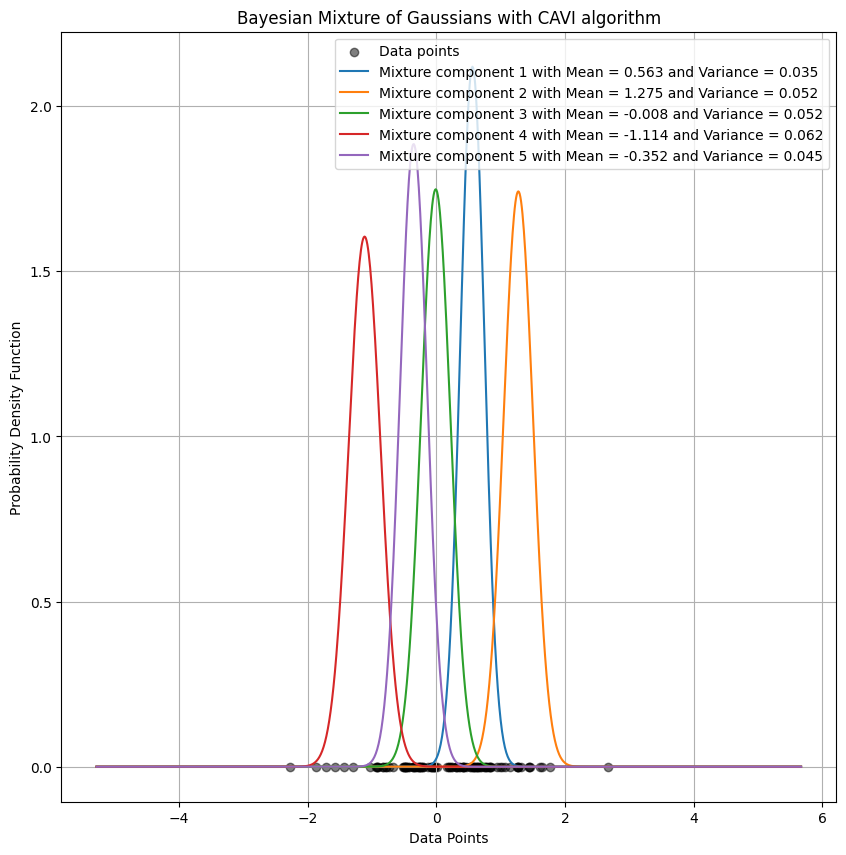

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def cavi_algorithm(data_points, num_data_point, num_cluster, prior_variance, max_iterations):
    # Initialize posterior responsibilities (q‐values), cluster means and variances
    cavi_distribution = np.zeros((num_data_point, num_cluster))
    cluster_means = np.random.randn(num_cluster)
    cluster_variances = np.ones(num_cluster) * prior_variance

    two_pi = 2 * np.pi
    inv_prior = 1.0 / prior_variance

    for iteration in range(max_iterations):
        # 1) E‐step (update cavi_distribution row by row)
        #    For each cluster j we compute the log‐density of a Gaussian at all points
        #    Then exponentiate and normalize across clusters for each data point.
        for j in range(num_cluster):
            # compute log p(x_i | μ_j, σ²_j) for all i at once
            var_j = cluster_variances[j]
            diff = data_points - cluster_means[j]
            log_prob = -0.5 * np.log(two_pi * var_j) - (diff ** 2) / (2 * var_j)
            cavi_distribution[:, j] = np.exp(log_prob)

        # Normalize responsibilities so that each row sums to 1
        row_sums = np.sum(cavi_distribution, axis=1, keepdims=True)
        cavi_distribution /= row_sums

        # 2) M‐step (update cluster_means and cluster_variances)
        #    For each cluster k, compute the effective “weight” and then update μ_k and σ²_k
        weights = np.sum(cavi_distribution, axis=0)  # length = num_cluster
        for k in range(num_cluster):
            w_k = weights[k]
            # Update mean: (Σ_i q_i_k x_i) / (w_k + 1/prior_variance)
            numerator = np.dot(cavi_distribution[:, k], data_points)
            cluster_means[k] = numerator / (w_k + inv_prior)
            # Update variance: 1 / (w_k + 1/prior_variance)
            cluster_variances[k] = 1.0 / (w_k + inv_prior)

        # 3) Compute ELBO (for monitoring convergence)
        #    First term: Σ_{i,j} q_i_j * [log p(x_i | μ_j, σ²_j)]
        #    Second term: − Σ_i Σ_j q_i_j log q_i_j
        elbo = 0.0

        # Likelihood term
        for m in range(num_cluster):
            var_m = cluster_variances[m]
            diff_all = data_points - cluster_means[m]
            log_prob_all = -0.5 * np.log(two_pi * var_m) - (diff_all ** 2) / (2 * var_m)
            elbo += np.dot(cavi_distribution[:, m], log_prob_all)

        # Entropy term (−E_q[log q])
        # (add a tiny constant inside the log to prevent log(0))
        elbo -= np.sum(cavi_distribution * np.log(cavi_distribution + 1e-10))

        print(f"For {iteration + 1} iterations: ELBO = {elbo:.3f}")

    print(f"Final cluster means = {cluster_means}")
    print(f"Final cluster variances = {cluster_variances}")

    return cavi_distribution, cluster_means, cluster_variances, num_cluster


def plot_cavi(data_points, num_cluster, cluster_means, cluster_variances):
    plt.figure(figsize=(10, 10))
    plt.scatter(
        data_points,
        np.zeros_like(data_points),
        color='black',
        marker='o',
        label='Data points',
        alpha=0.5
    )

    data_range = np.linspace(np.min(data_points) - 3, np.max(data_points) + 3, 1000)

    for a in range(num_cluster):
        std_a = np.sqrt(cluster_variances[a])
        gaussian_pdf = (
            1
            / (std_a * np.sqrt(2 * np.pi))
            * np.exp(-0.5 * ((data_range - cluster_means[a]) / std_a) ** 2)
        )
        plt.plot(
            data_range,
            gaussian_pdf,
            label=(
                f"Mixture component {a + 1} with "
                f"Mean = {cluster_means[a]:.3f} and Variance = {cluster_variances[a]:.3f}"
            )
        )

    plt.title('Bayesian Mixture of Gaussians with CAVI algorithm')
    plt.xlabel('Data Points')
    plt.ylabel('Probability Density Function')
    plt.legend()
    plt.grid()
    plt.savefig('CAVI_algorithm')
    plt.show()


# ----------
# Example usage.
# ----------

data_points = np.random.randn(100)
num_data_point = len(data_points)
num_cluster = 5
prior_variance = 1.0
max_iterations = 100

cavi_distribution, cluster_means, cluster_variances, num_cluster = cavi_algorithm(
    data_points, num_data_point, num_cluster, prior_variance, max_iterations
)
plot_cavi(data_points, num_cluster, cluster_means, cluster_variances)
